**Deep Learning mini Project: Task 2 Text Generation by using William Shakerspere Sonnets**

*Author: Muhammad Faizan*

**Task Description**

For text generation you are required to use the Irish Songs dataset/Shakespeare sonnets dataset. (your trained model should be able to generate text given some seed and number of next words) (test file will only contain load model and then will be given some seed text and next words as no performance metrics in text generation.)

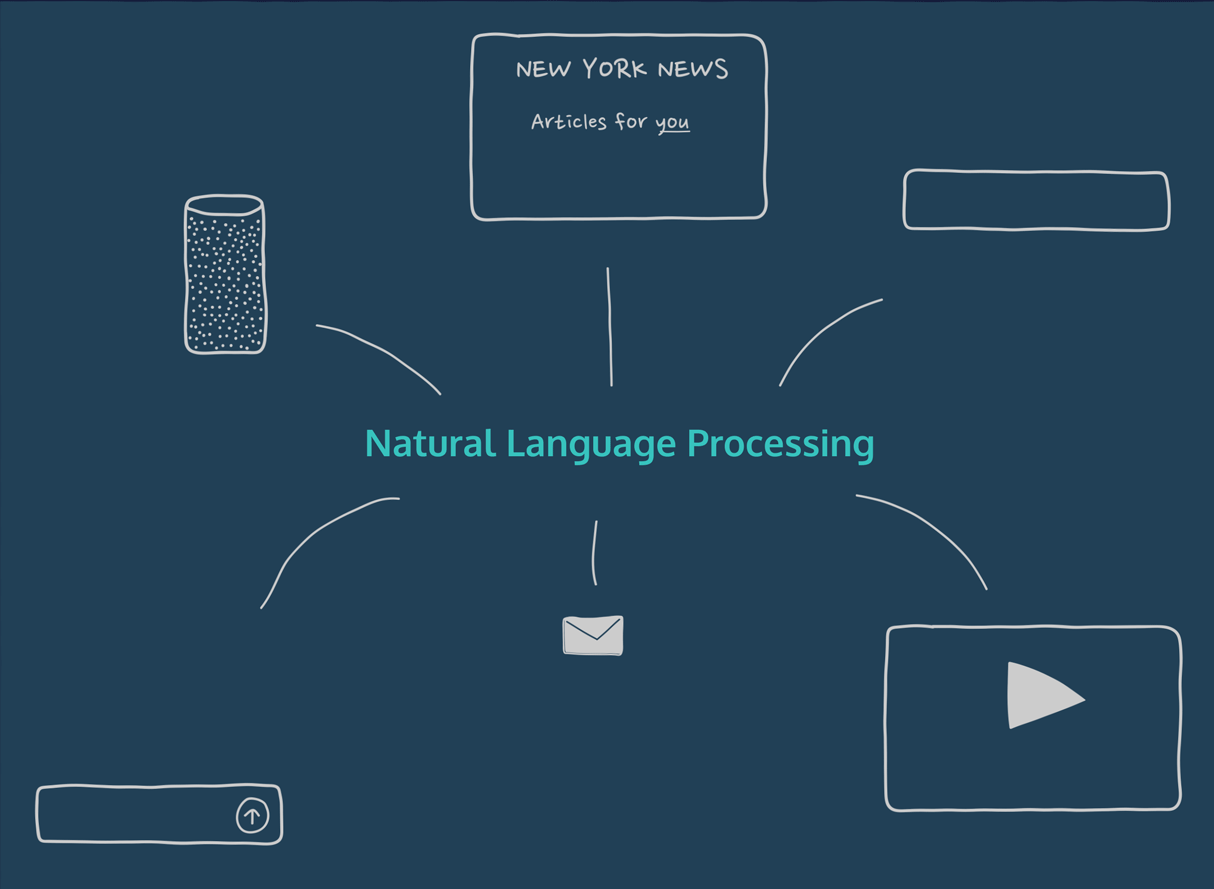

**The model**

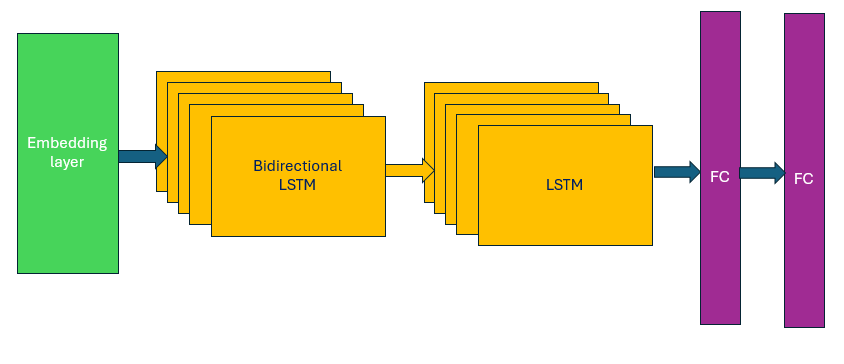

In [29]:
'''all the neccessary imports
since I am using TensorFlow as my deep learning framework for coding, so
all the implementation of the model is in tensorflow

Below is the breif description of the libraray and their usage
-------------------------------------------------------------
author: Muhammad Faizan
Date: 18 Dec 2023
Subject: Deep Learning
Instructor: Dr. Jawad Khan
-------------------------------------------------------------
Numpy: sceintific computing
os: operating system lib to interact with files and folders
Pandas: data manipulation
Matplotlib: Plotting
TensorFlow: Deep Learning programming framework
WordCloud: data of words and plotting utitlities
--------------------------------------------------------------
'''
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras.utils as ku
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

In [30]:
%cd /home

/home


In [31]:
# prompt: link google colab with drive
# mount dataset and notebook for google drive for non stop training
from google.colab import drive
drive.mount('gdrive')


Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).


In [32]:
%ls

gdrive/  poemcloud.png


In [33]:
%pwd

'/home'

In [34]:
# path to  sonnnet dataset file
path = '/home/gdrive/MyDrive/sonet_data/Sonnet.txt'

# check if the file at the specifed path exits?
try:
  data = open(path).read()
except FileNotFoundError:
  print(f'{path} file not found')

In [35]:
# print some content from the data
data[:500]

'\ufeffTHE SONNETS\n\nby William Shakespeare\n\nFrom fairest creatures we desire increase,\nThat thereby beauty’s rose might never die,\nBut as the riper should by time decease,\nHis tender heir might bear his memory:\nBut thou, contracted to thine own bright eyes,\nFeed’st thy light’s flame with self-substantial fuel,\nMaking a famine where abundance lies,\nThyself thy foe, to thy sweet self too cruel:\nThou that art now the world’s fresh ornament,\nAnd only herald to the gaudy spring,\nWithin thine own bud buries'

In [36]:
# by using WordCloud libraray to print some text from the data upto 50 font max,
# the number os words should be 100 with the white background
wordcloud = WordCloud(max_font_size=50, max_words=100,
                   background_color="white").generate(data)

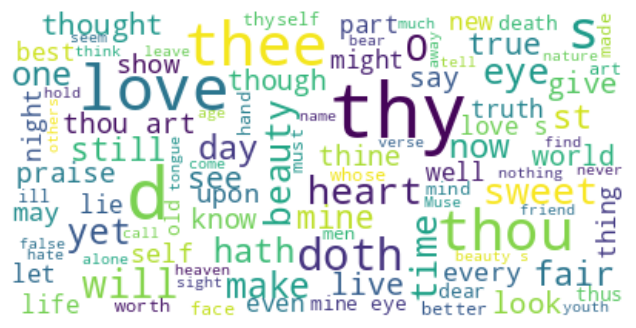

In [38]:
# plot the wordcloud using matplotlib
plt.rcParams['savefig.dpi'] = 300
plt.figure(figsize = (8,4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("poemcloud.png")
plt.show()

In [39]:
'''
Preprocessing: covnert the text to lower case alphabets and split
in lines seperated by a new line in the document. i.e

I love coding
I love machine learning
I love NLP

so here the code will first convert everyting to lower case and then
it will seperate it \n into ["i love coing", "i love machine lenaring", "i love nlp"]
'''
corpus = data.lower().split("\n")
corpus[:5]

['\ufeffthe sonnets',
 '',
 'by william shakespeare',
 '',
 'from fairest creatures we desire increase,']

In [40]:
# calcualte the size of each line in the document and analyze by pandas describe function
length = []
for line in corpus:
    length.append(len(line))
pd.Series(length).describe()

count    2599.000000
mean       35.758369
std        16.747965
min         0.000000
25%        37.000000
50%        42.000000
75%        45.000000
max        61.000000
dtype: float64

In [41]:
# ignore the white spaces in the doucment and only append actual words
corpus_new = []
for i in corpus:
    if len(i) == 0:
        continue
    else:
        corpus_new.append(i)

In [42]:
# calculate the length of new corpous by ignoring white spaces
length_new = []
for line in corpus_new:
    length_new.append(len(line))
pd.Series(length_new).describe()

count    2157.000000
mean       43.085767
std         4.705873
min        12.000000
25%        40.000000
50%        43.000000
75%        46.000000
max        61.000000
dtype: float64

In [75]:
'''
Preporcessing: Tokenization
---------------------------
we are fitting the tokenizer to tokenize the text into token like words such as unigram,
bigram, or trigram models
'''
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index)


In [64]:
input_lines = []
line = "The world is so confusing."
tokens = tokenizer.texts_to_sequences([line])[0]
for i in range(1, len(tokens)):
		n_gram_sequence = tokens[:i+1]
		input_lines.append(n_gram_sequence)


In [80]:

'''
encode the text and save the n_gram_sequences in input_sequences
Encode the text
padd the text with maximum padding sentence
seperate predictors from the labels
one-hot encoding of the labels
'''
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

# find the sequence with the maximum length  and the pad the sequence with the maximum
# length of the sequence and convert them to numpy arrays
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# seperate the predictors form the label and convert labels to one-not encoding
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
label = ku.to_categorical(label, num_classes=total_words+1)

In [81]:
'''
Create a sequential model using LSTM
Create a each word embedding using embedding layer with total_words + 1
the sequence length should be maximum_sequence - 1 because the last word is reserved
for the labels

Using Bidirectional LSTM with 150 embeddign space
using dropout of 20% to avoid overffiting
Using another 100 dimensions LSTM layer
and then adding Fully connected layers on the top for predicixton
with softmax activation

We are compiling the model with categorical cross entropy loss and with using
Adam optimizer with accuracy as our metric.
'''

model = Sequential()
model.add(Embedding(total_words+1, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words+1/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words+1, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 100)           323500    
                                                                 
 bidirectional (Bidirection  (None, 10, 300)           301200    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 10, 300)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 3234)              326634    
                                                                 
 dense_1 (Dense)             (None, 3235)              10465225  
                                                        

In [ ]:
# train the model on the preporcessed datset for 150 epochs and show the progress
history = model.fit(predictors, label, epochs=150, verbose=1)

Epoch 1/150
484/484 [==============================] - 22s 27ms/step - loss: 6.8876 - accuracy: 0.0208
Epoch 2/150
484/484 [==============================] - 6s 12ms/step - loss: 6.5111 - accuracy: 0.0220
Epoch 3/150
484/484 [==============================] - 5s 11ms/step - loss: 6.3938 - accuracy: 0.0276
Epoch 4/150
484/484 [==============================] - 5s 10ms/step - loss: 6.2728 - accuracy: 0.0322
Epoch 5/150
484/484 [==============================] - 6s 11ms/step - loss: 6.1804 - accuracy: 0.0365
Epoch 6/150
484/484 [==============================] - 5s 10ms/step - loss: 6.0947 - accuracy: 0.0391
Epoch 7/150
484/484 [==============================] - 6s 12ms/step - loss: 6.0167 - accuracy: 0.0409
Epoch 8/150
484/484 [==============================] - 5s 10ms/step - loss: 5.9300 - accuracy: 0.0438
Epoch 9/150
484/484 [==============================] - 5s 10ms/step - loss: 5.8313 - accuracy: 0.0514
Epoch 10/150
484/484 [==============================] - 7s 14ms/step - loss: 5.73

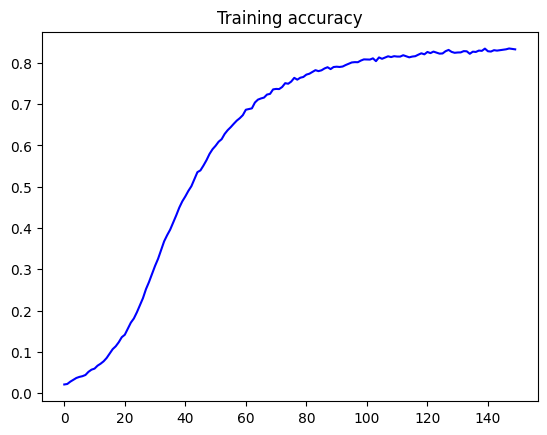

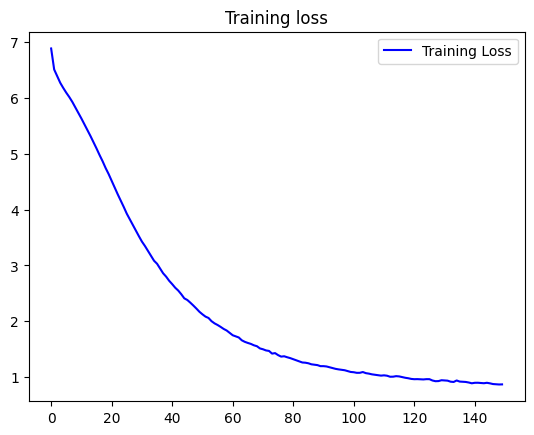

In [ ]:
# plot the training and validation accuracy over the given epochs
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [ ]:
"""
Illustration of model performance on the text data,
we are creating a simple seed text and feed it into the train model
for generating the text with 300 word limit
"""
seed_text = "I love you, but"
next_words = 300

for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)